# K-Means Clustering Intuition and Python Implementation

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import cv2

Let's explain the code at the bottom. Since we do not have a dataset, we are basically creating a dataset using numpy. So:

* __np.array[x,y]__ will create a numpy array with with elements [x,y]

* __np.random.randn(x,y)__ will generate random floats from a univariate "Guassian" distribution with mean 0 and variance 1. It will create an x-by-y array of samples. We can generalize to any random samples from _N(mu, sigma^2)_ by doing the formula __sigma * np.random.randn(...) + mu__. This is exactly what we are doing below.

* __np.vstack__ will stack the arrays together, so that we get a single point cloud made of random numbers generated from normal distributions around different means with different variances.

In [6]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))

I will print the first 10 points to show that they have been stacked.

In [7]:
print(points[0:9])

[[ 1.28928934 -0.13354883]
 [ 1.73254245 -0.00426401]
 [ 2.65320482  1.50756643]
 [ 1.11915604 -0.75302738]
 [ 2.0970585   1.14991472]
 [ 1.91475908  0.38057553]
 [ 1.5983608   0.07986449]
 [ 0.71407536  0.68451029]
 [ 0.00630855 -0.2848316 ]]


Now we plot x and y coordinates, and visualize the cluster centers. To do this, we use __plt.gca()__ which will get the current instance of the axes object.

The __ax.add_artist__ method creates an artist object. The artist object knows how to use the renderer to draw onto the canvas. We then plot using the __plt.Circle()__ method. Note we are centering the circles at the mean, with the radius being half the variance. 

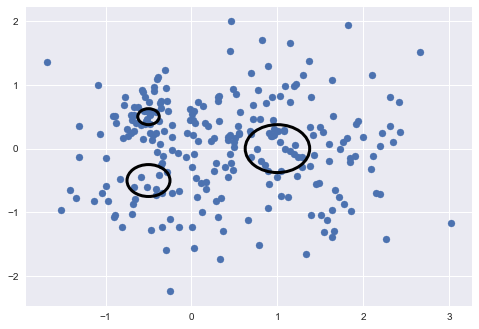

In [8]:
plt.scatter(points[:,0], points[:,1])
ax = plt.gca()
ax.add_artist(plt.Circle(np.array([1, 0]), 0.75/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, 0.5]), 0.25/2, fill=False, lw=3))
ax.add_artist(plt.Circle(np.array([-0.5, -0.5]), 0.5/2, fill=False, lw=3))

Now we will use the existing dataset to initialize k centroids. This is done by first copying all the points using __points.copy()__. Then we will use __np.random.shuffle(X)__ to shuffle along the first axis of X. So the x,y pairs will be retained, just shuffled.

Then we will select the first k rows __X[:k]__ to initialize the centroids, and return that spliced array.

In [9]:
def initialize_centroids(points, k):
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

Then we can see the output of this function

In [10]:
initialize_centroids(points, 3)

array([[  7.18938836e-04,  -1.21981113e+00],
       [  1.29347257e+00,   1.14463061e+00],
       [  3.00411973e-02,   5.82738771e-01]])

As before, we will plot all of the points in the scatter plot, and we will also plot the centroids. __s__ is area, and __c__ is color.

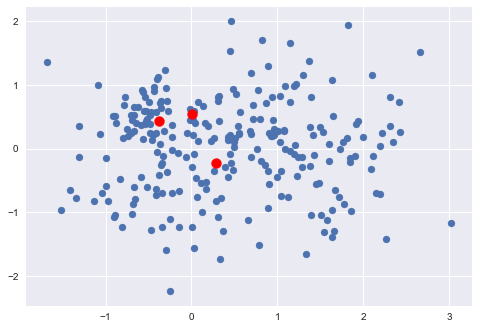

In [11]:
plt.scatter(points[:,0], points[:,1])
centroids = initialize_centroids(points, 3)
plt.scatter(centroids[:,0], centroids[:,1], c = 'r', s = 100)

## Broadcasting arrays for efficiency

We now want to find the 2 norm of the distance between the distances between each of the points and the corresponding centroids. In this way, we will cluster the points to the centroids.

Now how can we efficiently find the 2 norm for each of these centroids? We do this using array broadcasting. [Broadcasting Documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html), and a good [visualization](http://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc) are linked. 

Firstly, we know that the size of the points will be __[x, 2]__, and the size of the centroids will be __[k, 2]__. We want the final array to be of size __[k,x,2]__. This means we can split the final array into __k__ centroids each containing the 2 dimensional differences for the __x__ points.

So we will add a new axis to the centroids, making the size __[k,1,2]__. Then we can subtract all of the points. I have given a small example below.

In [12]:
centroids.shape

(3, 2)

In [13]:
points[:10].shape

(10, 2)

We can add an extra axis using the __np.newaxis__ method.

In [14]:
c_test = centroids[:, np.newaxis, :]
c_test.shape

(3, 1, 2)

Now if we subtract the centroid values from the points, python will automatically broadcast the middle axis that we added to 250, essentially stretching the array 250 times in that direction. Then the same subtraction is completed. Note the shape of the new array.

In [15]:
c_diff = points - c_test
c_diff.shape

(3, 250, 2)

If we plot this array, we can see how the subtractions for each of the clusters is now neatly grouped by centroid.

In [16]:
print(c_diff)

[[[ 1.66649113 -0.56333561]
  [ 2.10974424 -0.43405079]
  [ 3.03040661  1.07777966]
  ..., 
  [ 0.32923014 -0.17929601]
  [-1.03449628 -1.07768973]
  [-0.29442587 -1.03585747]]

 [[ 1.27879535 -0.66930659]
  [ 1.72204846 -0.54002177]
  [ 2.64271083  0.97180867]
  ..., 
  [-0.05846564 -0.28526699]
  [-1.42219206 -1.18366072]
  [-0.68212165 -1.14182845]]

 [[ 1.00423458  0.09754812]
  [ 1.44748769  0.22683294]
  [ 2.36815006  1.73866338]
  ..., 
  [-0.33302641  0.48158772]
  [-1.69675283 -0.41680601]
  [-0.95668241 -0.37497374]]]


Now we can take 2 norm of these differences. First we square and sum the values. Note that the shape has now become __[3,250]__ because we have summed across the 2nd axis, meaning we added the x and y values.

In [17]:
c_testnorm = (c_diff**2).sum(axis=2)
print(c_testnorm.shape)

(3, 250)


And then finally we take the square root value. Note that the size will still remain __[3,250]__.

In [18]:
c_testnorm = np.sqrt(c_testnorm)
print(c_testnorm.shape)

(3, 250)


## ...Back to the problem

Now we can go back to the problem and implement the same code for our entire array of points. At the end, we want to find which of the centroids the minimized point belongs to, so we do an __np.argmin__ method along axis = 0. This means that we compare each of the 2 norms for the 3 centroids, and find which one is closest, returning the index of that centroid for each point.

In [19]:
def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis,:])**2).sum(axis=2))
    return np.argmin(distances, axis = 0)

We can use this function show the indexed points returned.

In [20]:
c = initialize_centroids(points,3)
close_centroid = closest_centroid(points, centroids)
print(close_centroid)

[2 2 1 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 1 0 2 0 2 2 2 1 1 1 2 1 1 1 2 1 2 2
 1 2 2 2 2 2 1 1 1 2 1 2 1 2 1 2 2 2 1 1 1 2 2 2 2 2 2 2 0 2 2 2 2 1 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 2 2 2 2 1 2 1 2 2 2 1 2 2 1 1
 2 2 2 1 2 2 1 1 2 2 2 0 2 2 2 1 2 2 1 2 0 2 0 2 2 1 2 2 2 2 2 2 2 2 0 1 2
 1 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 2 2 0 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 2
 2 2 0 2 2 0 1 0 0 2 2 2 0 2 0 2 0 2 0 2 0 0 1 2 2 1 0 2]


Now we need to find the mean values for all of these clusters to obtain the position of the new centroids. We will do this by first creating a mask, for example for the third cluster. This will provide a boolean matrix, which we can use to slice the points matrix.

In [51]:
points[close_centroid == 2][0:10]

array([[ 1.28928934, -0.13354883],
       [ 1.73254245, -0.00426401],
       [ 1.11915604, -0.75302738],
       [ 1.91475908,  0.38057553],
       [ 1.5983608 ,  0.07986449],
       [ 0.00630855, -0.2848316 ],
       [ 1.6359013 , -0.9606338 ],
       [ 0.89206565, -0.93047323],
       [ 2.34608647,  0.09876388],
       [ 0.99161464, -0.44961573]])

Then we just take the mean of these points along the rows to give us the position of a new centroid. 

In [22]:
points[close_centroid == 2].mean(axis = 0)

array([ 0.82982215, -0.40101994])

Implementing this into a function

In [23]:
def move_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis = 0) for k in range(centroids.shape[0])])

In [24]:
move_centroids(points, closest_centroid(points, c), c)

array([[ 1.04443243,  0.16291825],
       [-0.40200767, -0.07906841],
       [-1.17827644, -0.54175309]])

We can plot this motion of the centroids as follows

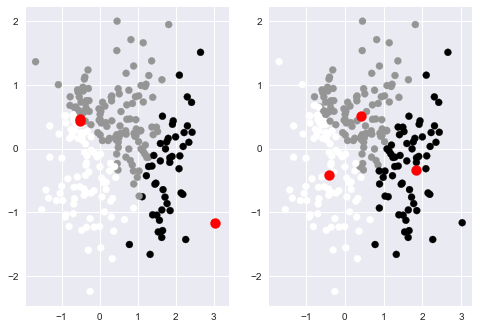

In [25]:
plt.subplot(121)
centroids = initialize_centroids(points,3)
closest = closest_centroid(points, centroids)
plt.scatter(points[:, 0], points[:,1], c = closest)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'r', s = 100)

plt.subplot(122)
centroids = move_centroids(points, closest, centroids)
closest = closest_centroid(points, centroids)
plt.scatter(points[:, 0], points[:,1], c = closest)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)

Now let us create a small animation to show the centroids moving to their optimal positions. To do this, we will use __matplotlib__ animations. I am also going to use __JSAnimation__ to display these animations in HTML. 

In [26]:
from matplotlib import pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display

First we will create an empty figure and initialize the centroids.

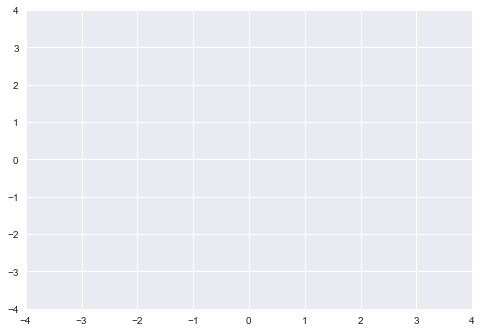

In [27]:
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-4, 4))
line, = ax.plot([], [], lw=2)
centroids = initialize_centroids(points, 3)

Since we need to then animate by reassigning values to the centroid variable, we will assign it with a __global__ inside the animate function. Then note how we are clearing the axis each frame and replotting.

In [28]:
def init():
    line.set_data([], [])
    return line,

def animate(i):
    global centroids
    closest = closest_centroid(points, centroids)
    centroids = move_centroids(points, closest, centroids)
    ax.cla()
    ax.scatter(points[:, 0], points[:, 1], c=closest)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)
    return line,

Finally we call the FuncAnimation method. We will do 10 frames with a 200ms delay between each frame. We are also using blitting, which will save on computation.


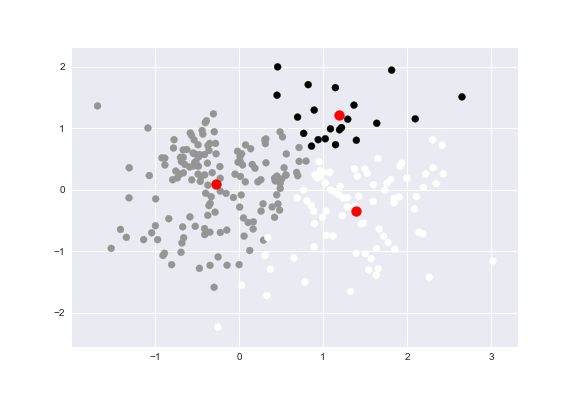
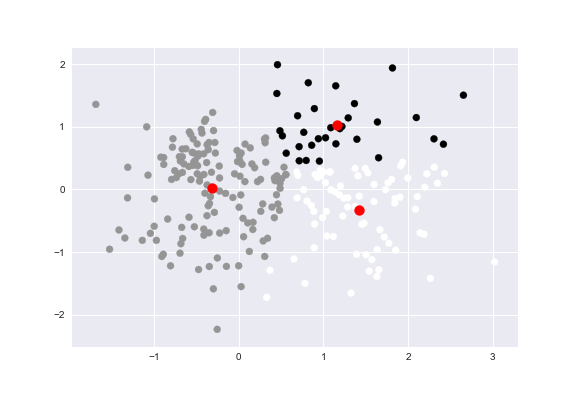
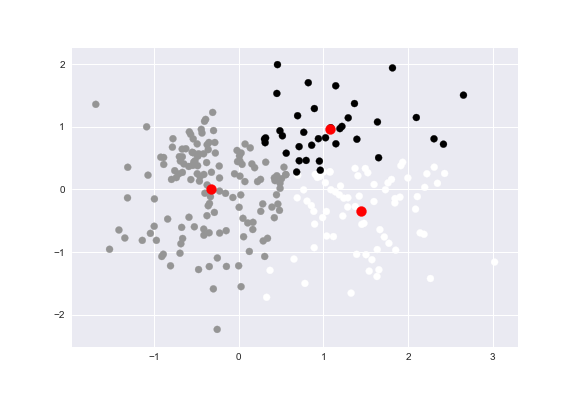
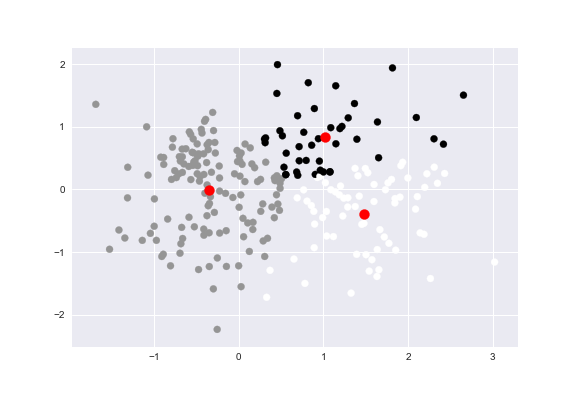
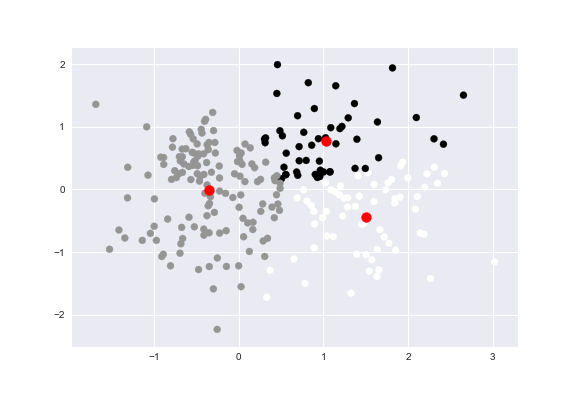
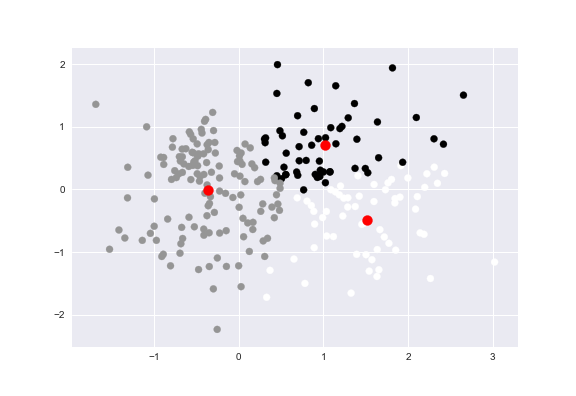
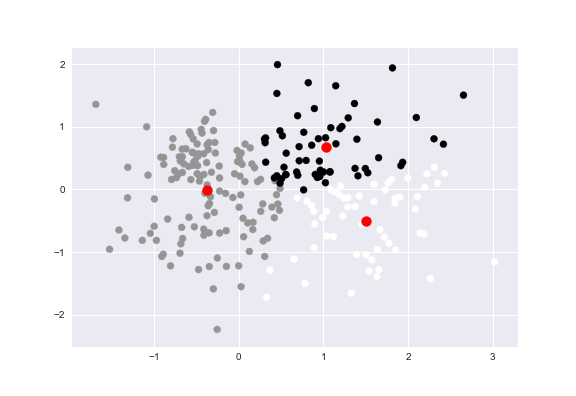
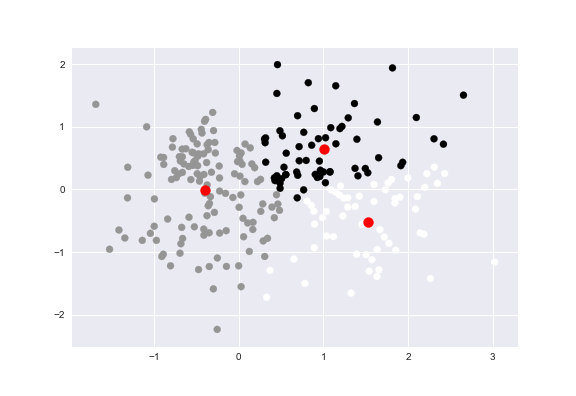
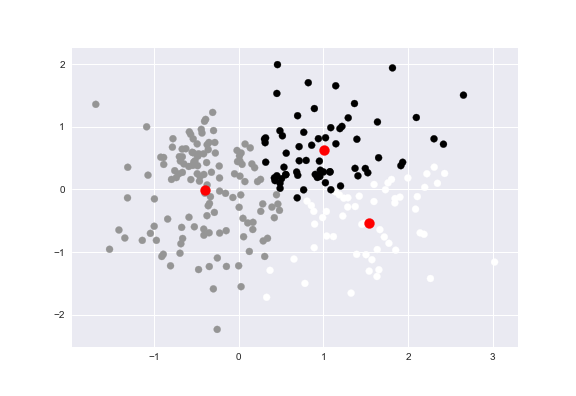
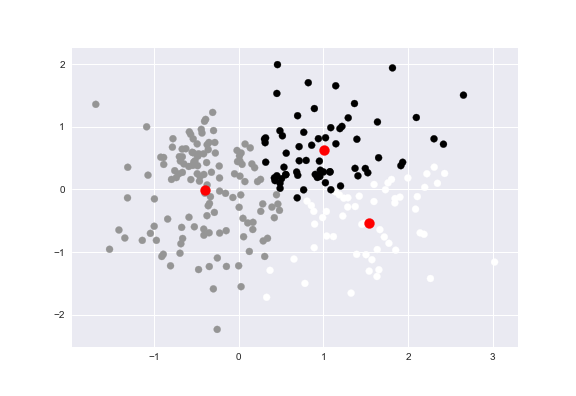

In [29]:
animation.FuncAnimation(fig, animate, init_func=init,
                        frames=10, interval=200, blit=True)

# A real example of RGB Image Segmentation

Now let's apply this to a real example of color segmentation in an image. To do this, we will first import the image we want to segment using openCV. Note just out of interest I have included both the RGB and the greyscale images, though we will only be using the RGB image. 

Also note that openCV will import color images as BGR rather than RBG. To convert to RGB, we will use openCV's __cv.split()__ and __cv.merge()__ methods.

In [30]:
import cv2

bgr_img = cv2.imread('C:/Users/samya/Documents/Python Scripts/elephant.jpg')
b, g, r = cv2.split(bgr_img)
rgb_img = cv2.merge([r,g,b])
grs_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

Here are the images so you can see what we are working with.

<function matplotlib.pyplot.show>

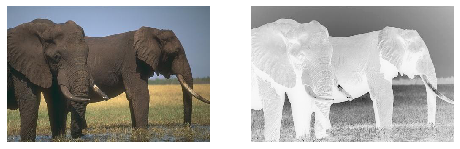

In [31]:
plt.subplot(121)
plt.imshow(rgb_img)
plt.xticks([]), plt.yticks([])
plt.show

plt.subplot(122)
plt.imshow(grs_img)
plt.xticks([]), plt.yticks([])
plt.show

Next we will look at the shape of the RGB image below. We will save the dimensions of the image as _d1_ and _d2_. Note that there are 3 channels, one for red, green and blue.

In [32]:
rgb_img.shape

(321, 481, 3)

In [33]:
d1, d2, d3 = rgb_img.shape

Next we shall reshape the array into 3 column vectors, one for each of RBG.

In [34]:
col_rgbImg = rgb_img.reshape(d1*d2, d3)

Next we will define the function for initializing centroids from the given dataset. We will also define the functions for finding the closest centroids and moving the centroids by the mean. If you are unfamiliar with these functions, then see above for a detailed explanation of how they work.

In [35]:
def initialize_centroids(points, k):
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis,:])**2).sum(axis=2))
    return np.argmin(distances, axis = 0) 

def move_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis = 0) for k in range(centroids.shape[0])])

Now we will create a function that will run for a particular number of iterations for a certain value of k, and subsequently give the output as the segmented image. Let us first go through the function step by step before implementing it in a function. First as before, we will initialize our centroids, taking k = 2.

In [36]:
k = 2
centroids = initialize_centroids(col_rgbImg, k)

Next we will define a variable for the maximum iterations, and iteratively cluster and move the centroids until the maximum iterations have been reached.

In [37]:
m_iter = 20
for i in range(m_iter):
        closest = closest_centroid(col_rgbImg, centroids)
        centroids = move_centroids(col_rgbImg, closest, centroids)

Then we will do a final clustering of the points using the new centroid locations

In [38]:
closest = closest_centroid(col_rgbImg, centroids)

We will use the boolean matrix created to replace all of the points with the values of their respective clusters. You can see this has worked when we print the new matrix.

In [39]:
for k in range(centroids.shape[0]):
    col_rgbImg[closest == k] = centroids[k] 

In [40]:
col_rgbImg

array([[143, 148, 147],
       [143, 148, 147],
       [143, 148, 147],
       ..., 
       [ 78,  70,  59],
       [ 78,  70,  59],
       [ 78,  70,  59]], dtype=uint8)

Finally we reshape the column matrix into the original shape, and plot it. 

In [41]:
rec_img = col_rgbImg.reshape(d1,d2,d3)

<function matplotlib.pyplot.show>

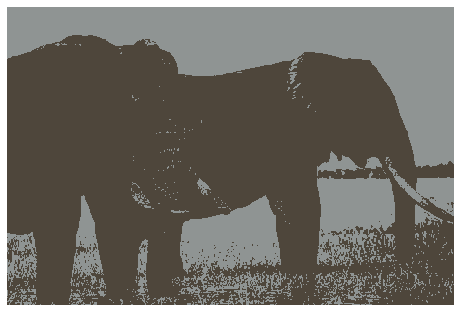

In [42]:
plt.imshow(rec_img)
plt.xticks([]), plt.yticks([])
plt.show

Notice that the image is now segmented into 2 colors. Let us implement this entire thing into a function, and see what the output looks like for segmentations with a higher k value.

In [43]:
def segment_img(points, k, m_iter):
    centroids = initialize_centroids(points, k)
    
    for i in range(m_iter):
        closest = closest_centroid(points, centroids)
        centroids = move_centroids(points, closest, centroids)
    
    closest = closest_centroid(points, centroids)
    col_rgbImg2 = points.copy()
    
    for k in range(centroids.shape[0]):
        col_rgbImg2[closest == k] = centroids[k]  
    
    return col_rgbImg2

Running the code for 4 different values of k with an iteration of 20, we get the following outputs. Note that in each image, the k will give you the number of different colors that the image is segmented into. This is the entire idea between k-clustering.

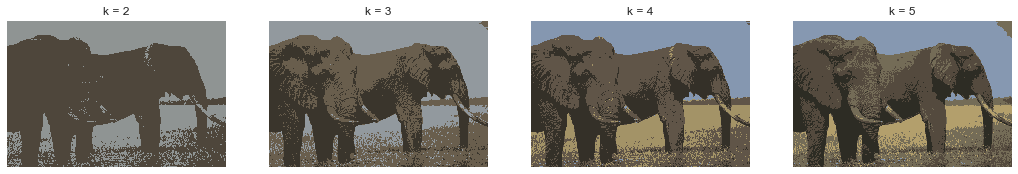

In [44]:
bgr_img = cv2.imread('C:/Users/samya/Documents/Python Scripts/elephant.jpg')
b, g, r = cv2.split(bgr_img)
rgb_img = cv2.merge([r,g,b])
grs_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

d1, d2, d3 = rgb_img.shape
col_rgbImg = rgb_img.reshape(d1*d2, d3)

m_iter = 50
rec_img = np.zeros((d1*d2, 3))

fig, axes = plt.subplots(1,4, figsize=(18, 16))
for k in range(2, 6):
    rec_img = segment_img(col_rgbImg, k, m_iter)
    
    new_img = rec_img.reshape(d1,d2,d3)
    
    axes[k-2].set_xticks([]) 
    axes[k-2].set_yticks([])
    axes[k-2].set_title('k = ' + str(k))
    axes[k-2].imshow(new_img)